# GitHub Activity Summary for Project Jupyter

Using the GitHub public APIs, we compute some basic activity metrics for the project.  

Note that, [as explained in the GitHub documentation](https://developer.github.com/v3/activity/events/#events), we are limited both to at most 300 events and at most 90 days of activity.  So all activity tables presented here will never have more than 300 entries or go back further than 90 days, regardless of how active the user may be.  On their website, GitHub does display activity for a user over a full year, but they don't make that data available over their API.

## Basic setup

First, load some basic libraries we'll need later.

In [55]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg', 'pdf']
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import github3 as gh
# Python stdlib
import datetime as dt
import functools
import getpass
import sys
from collections import OrderedDict
# Pandas global settings - two digit printing for percentages
pd.set_option('precision', 2)
pd.set_option('display.max_columns', 8)

**A Note on Authentication**

This notebook can run without authentication, but you will not be able to execute the code against the entire list of KBase project members, since GitHub rate-limits unauthenticated requests to [60 per hour](https://developer.github.com/v3/#rate-limiting).  If you want to run with authentication, put in your GitHub username and passsword in the cell below, otherwise leave it commented out.

In [56]:
# Put your own user name here, and input your password below when prompted
gh_auth = gh.login('fperez', password=getpass.getpass("Password:"))
gh = gh_auth # Need to use auth for this to run to completion

Password:········


Let's list the organizations we're interested in gathering activity about, and using the GitHub API, we ask for the developers who belong to these orgs:

In [84]:
organizations = ['jupyter', 'jupyter-incubator', 'ipython']
people = []

for oname in organizations:
    people.extend([m.login for m in gh.organization(oname).members()])

people = sorted(set(people))  # Avoid repetitions
people

['Carreau',
 'IanHawke',
 'KesterTong',
 'MatthewTurk',
 'MohamedElKamhawy',
 'SylvainCorlay',
 'aggFTW',
 'aisipos',
 'alope107',
 'ananelson',
 'blink1073',
 'bollwyvl',
 'cameronoelsen',
 'captainsafia',
 'damianavila',
 'dwillmer',
 'ellachao',
 'ellisonbg',
 'fhoffa',
 'fperez',
 'gnestor',
 'ivanov',
 'jasongrout',
 'jdfreder',
 'jeremiahbuddha',
 'jhamrick',
 'jsnydes',
 'jstenar',
 'jtigani',
 'jtyberg',
 'juliantaylor',
 'kayur',
 'lbustelo',
 'lphk92',
 'marksandler2',
 'minrk',
 'msftristew',
 'ocefpaf',
 'parente',
 'priscilla-lee',
 'randallmunroe',
 'rgbkrk',
 'richvn',
 'rkern',
 'sangeethashekar',
 'sccolbert',
 'slojo404',
 'smashwilson',
 'ssanderson',
 'sumitsahrawat',
 'svurens',
 'szeitlin',
 'takluyver',
 'vonmoltke',
 'williamstein',
 'willingc',
 'willnorris',
 'willwhitney']

We now define a few functions we'll use later on

In [58]:
@functools.lru_cache()
def get_source_login(repo):
    """Return the source login of a repository.
    
    This finds either the original source if the repository is a fork, or returns 
    the current owner's login if it's not a fork.
    """
    r = gh.repository(repo[0], repo[1])
    if r.source:
        return r.source.owner.login
    else:
        return r.owner.login

In [59]:
def get_gh_activity(login):
    """Build a DataFrame of user activity."""
    user = gh.user(login)
    s = []
    for e in user.events():
        etype = e.type.replace('Event', '')
        if etype == 'Push':
            size = e.as_dict()['payload']['size']
        else:
            size = 1
        # For events on repos owned by the user, we need to get the original source
        # of the repo, in case it's a fork of a KBase repo, so we can credit that.
        source = get_source_login(e.repo) if e.repo[0] == login else e.repo[0]
        if not source:
            # odd corner cases where we get back empty repo sources from github
            # that corrupt the pipeline further downstream
            source = e.repo[0]
        s.append([str(e.created_at.date()), e.repo[0], e.repo[1], source, etype, 
                  size])

    return pd.DataFrame(s, columns=['date', 'owner','repo_name', 
                                     'source', 'activity_type', 'size'])

In [60]:
def org_activity(stats, source):
    """Return an "activity score" for a user relative to an organization. 
    
    This is just the fraction of their activity in repos that trace back to that 
    organization (owned by that org or forks of it) relative to the user's overall 
    GH activity.
    
    Returned as a percentage (0-100)."""
    if len(stats) == 0:
        return 0
    else:
        return (100*stats[stats['source']==source]['size'].sum())/stats['size'].sum()

In [61]:
def activity_summary(login, stats, org='jupyter'):
    """Display an activity summary for a user, provided a data frame of activity.
    """
    print("Summary of GitHub Activity for user:", login)
    
    if len(stats) == 0:
        print("*** This user had NO Github activity for this period ***")
    else:
        total = stats['size'].sum()
        by_source = (100*stats['size']/total).groupby(stats['source']).sum()
        by_source.plot(kind='pie', legend=False, figsize=(3,3))
        kbase_act = org_activity(stats, org)
        plt.title('%s, total activity = %s, %s: %.1f %%,' % 
                  (login, total, org, kbase_act))
        plt.subplots_adjust(bottom=0.2) # prevent bottom clipping of labels
        plt.show()
        print("Activity grouped by repository (%):")
        print(by_source)
        
    print("-"*65)

## Summary of user activity for one user

With these functions, we can compute a summary of activity for one user.  

The `owner/repo` pair are basically the URL of the repo, but we also compute the 'source' of the repo, which is the original source in case the repo is a fork.  This lets us properly credit e.g. Push activity that was done to a personal repo that is a KBase fork, as part of work towards an eventual KBase pull request.

The `size` parameter is simply a count of the number of commits for Push events, which can consist of many commits bundled into a single event.  For now, all other types of events are considered to be of 'size 1'.

Summary of GitHub Activity for user: fperez


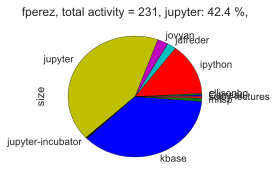

Activity grouped by repository (%):
source
Carreau               0.43
ellisonbg             0.43
ipython              13.85
jdfreder              2.16
jovyan                2.60
jupyter              42.42
jupyter-incubator     0.43
kbase                36.36
mltsp                 0.87
scipy-lectures        0.43
Name: size, dtype: float64
-----------------------------------------------------------------


In [62]:
uname = 'fperez'
stats = gh_activity(uname)
stats

We can now collect these same statistics for the entire team:

In [64]:
gh_summary = OrderedDict()
for member in people:
    gh_summary[member] = get_gh_activity(member)

While we can dig into these statistics for a fair amount of detail, a quick summary can be obtained by counting the activity by source.  For convenience, we'll write a little wrapper function that we can call with a simple user name and that assumes we have the above `gh_summary` dict holding all the user stats.  We can then use this wrapper utility later on to produce per-user reports interactively if desired.

Summary of GitHub Activity for user: fperez


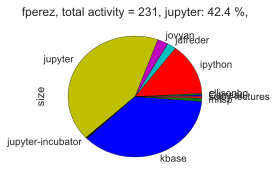

Activity grouped by repository (%):
source
Carreau               0.43
ellisonbg             0.43
ipython              13.85
jdfreder              2.16
jovyan                2.60
jupyter              42.42
jupyter-incubator     0.43
kbase                36.36
mltsp                 0.87
scipy-lectures        0.43
Name: size, dtype: float64
-----------------------------------------------------------------


In [65]:
def gh_activity(login):
    """Produce an activity summary for the given user login.
    
    This assumes the global `gh_summary` table holds data for all users."""
    try:
        stats = gh_summary[login]
    except KeyError:
        print("*** ERROR *** Data not available for user:", login, file=sys.stderr)
    else:
        activity_summary(login, stats)

# For example:
gh_activity('fperez')

# Integrated activity across all users

Now that we have collected everyone's data in `gh_summary`, we can build a common summary of the activity of all the project members in a single table that only contains the source and activity size.  This will make it easier to compute project-wide summary statistics.

We will call this global table `project_team`, and we will also build a companion summary series, `kbase_activity`, containing the individual activity totals, which can be handy to have.

In [66]:
d = OrderedDict() # overall stats for each member
a = OrderedDict() # individual activity total
inactive_members = []
for member, stats in gh_summary.items():
    if len(stats) == 0:
        inactive_members.append(member)
        continue
    a[member] = stats['size'].sum()
    d[member] = ((100*stats['size']/
                    stats['size'].sum(skipna=True)).groupby(stats['source']).sum())

project_team = pd.DataFrame(d).transpose().fillna(0)
project_activity = pd.Series(a, name='activity')

if inactive_members:
    print("Project members with no GitHub activity in the last 90 days:\n",
          inactive_members)

Project members with no GitHub activity in the last 90 days:
 ['ananelson', 'jeremiahbuddha', 'jsnydes', 'jtigani', 'marksandler2', 'randallmunroe', 'richvn', 'sangeethashekar', 'slojo404', 'svurens']


This `project_team` table now has all the team's activity, but it's a fairly large data structure, let's look at only a few rows for illustration.  Note that it's naturally a very sparse table, since most users (the rows) only have activity in a few orgs/sources (the columns):

In [67]:
project_team[:5]

222464  AGWA  ActivisionGameScience  Anaconda-Server  \
Carreau                0     0                      0                0   
IanHawke               0     0                      0                0   
KesterTong             0     0                      0                0   
MatthewTurk            0     0                      0                0   
MohamedElKamhawy       0     0                      0                0   

                   ...     zealdocs  zeromq  zfsonlinux  zingale  
Carreau            ...            0       0           0     0.00  
IanHawke           ...            0       0           0     0.00  
KesterTong         ...            0       0           0     0.00  
MatthewTurk        ...            0       0           0     2.17  
MohamedElKamhawy   ...            0       0           0     0.00  

[5 rows x 517 columns]

In order to do a bit of visualization of the team activity, we can plot this table as a heatmap. The problem is that it's simply too large. We can start by dropping all personal repos, which makes it smaller:

In [68]:
p0 = project_team.drop(project_team.columns.intersection(project_team.index), axis=1)
len(p0.columns)

484

But it's still very sparse.  It would be far easier to visualize if we drop all the columns containing repos below a certain activity threshold:

In [71]:
threshold = 20  # percentage
pp = p0.loc[:, (p0 > threshold).any(axis=0)]
print("Number of repos with more than %s%% activity: %s" %
      (threshold, len(pp.columns)))

Number of repos with more than 20% activity: 29


With this, we can build a much more readable heatmap. We'll sort it along the Jupyter column so that we can see who is actually active on the project more clearly (though keep in mind that this is only relative activity, not absolute, and it saturates at 100%):

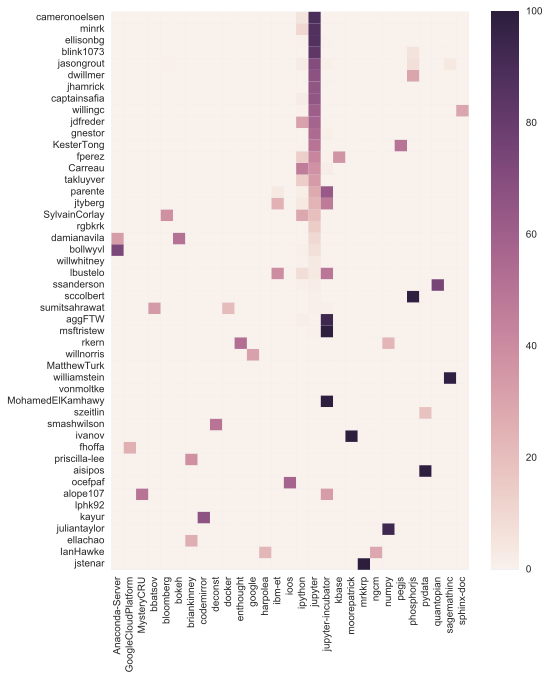

In [72]:
project_s = pp.sort_values(by='jupyter', ascending=False)
plt.figure(figsize=(8,10))
sns.heatmap(project_s);

It can be informative to look at the scaled value, multiplying the relative activity score by the user's total activity value, which produces:

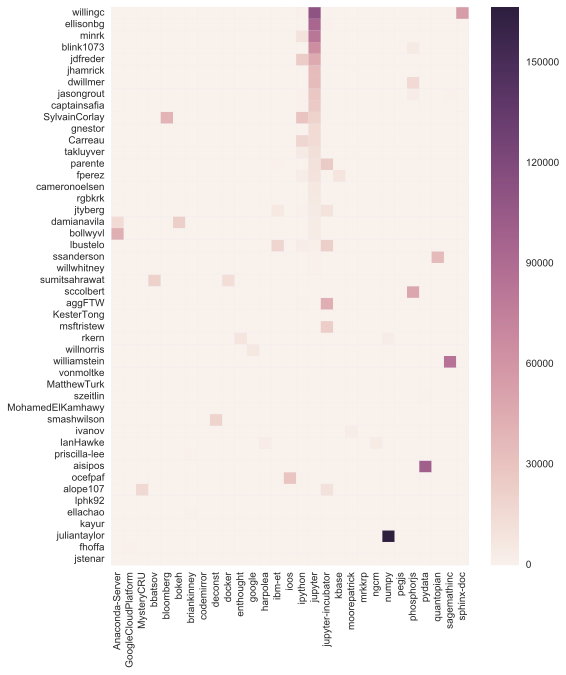

In [73]:
project_s2 = project_s.mul(project_activity, 
                           axis=0).sort_values(by='jupyter', ascending=False)
plt.figure(figsize=(8,10))
sns.heatmap(project_s2);

Now that we have `project_team` we can easily query further cross-team information. For example, let's write a simple function that returns the list of team members with activity above a given threshold in a given source:

In [74]:
def active_members(source='jupyter',threshold=0):
    """Return the list of all members with activity strictly above the given 
    threshold in the requested organization, along with their total activity score.
    
    This helps interpret their contribution to a given project in the context of
    their overall level of activity.
    """
    try:
        proj = project_team[source][project_team[source] > threshold ]
    except KeyError:
        return None
    p, act = proj.align(project_activity, join='inner')
    return pd.concat([p, act], axis=1)

These are all the project members with any recorded activity:

In [80]:
active_members('jupyter')

jupyter  activity
Carreau          37.60       383
KesterTong       50.00         2
SylvainCorlay    19.43      1045
aggFTW            0.44       457
blink1073        83.23       775
bollwyvl          7.19       584
cameronoelsen    89.47        76
captainsafia     65.23       394
damianavila       9.71       443
dwillmer         67.32       514
ellisonbg        87.11      1078
fperez           42.42       231
gnestor          54.44       270
jasongrout       70.56       394
jdfreder         57.92       789
jhamrick         65.48       533
jtyberg          23.83       214
lbustelo          3.42       468
minrk            87.11       939
msftristew        0.42       236
parente          27.53       396
rgbkrk           14.48       366
sccolbert         1.01       493
ssanderson        1.66       483
sumitsahrawat     0.82       611
takluyver        33.80       355
willingc         60.56      1833
willwhitney       3.45       203

We can use it to quickly query for activity on any other organization or source.  Since people can work on their personal repos, a 'source' can be an individual's own login as well:

In [78]:
active_members('minrk')

minrk  activity
ellisonbg   0.37      1078
gnestor     0.37       270
minrk       0.53       939

And we can just as easily query other sources:

In [81]:
active_members('ipython')

ipython  activity
Carreau          46.48       383
SylvainCorlay    28.61      1045
aggFTW            1.53       457
bollwyvl          1.03       584
cameronoelsen     5.26        76
captainsafia      2.54       394
ellisonbg         0.56      1078
fperez           13.85       231
jasongrout        2.54       394
jdfreder         30.93       789
jtyberg           3.27       214
lbustelo          7.69       468
minrk            10.44       939
parente           1.52       396
ssanderson        1.04       483
takluyver        14.37       355
willingc          0.55      1833
willwhitney       0.49       203

In [82]:
active_members('jupyter-incubator')

jupyter-incubator  activity
Carreau                        1.57       383
MohamedElKamhawy             100.00         1
aggFTW                        93.65       457
alope107                      32.92       319
ellisonbg                      0.65      1078
fperez                         0.43       231
gnestor                        1.11       270
jasongrout                     1.02       394
jhamrick                       0.19       533
jtyberg                       47.20       214
lbustelo                      49.57       468
msftristew                    99.58       236
parente                       63.13       396
sumitsahrawat                  0.82       611

# Graphical report across the entire team

With the data being available for the whole team, it is trivial to run `gh_activity` over the entire data set to generate a visual summary that can be informative, if lengthy:

Summary of GitHub Activity for user: Carreau


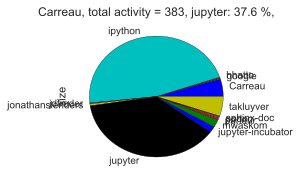

Activity grouped by repository (%):
source
Carreau               4.70
google                0.26
hhatto                0.26
ipython              46.48
jdfreder              0.26
jonathanslenders      0.52
jupyter              37.60
jupyter-incubator     1.57
mwaskom               2.09
parleur               0.52
podoc                 0.26
sphinx-doc            0.26
takluyver             5.22
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: IanHawke


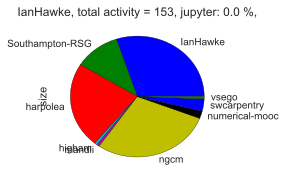

Activity grouped by repository (%):
source
IanHawke           30.07
Southampton-RSG    11.11
harpolea           22.88
higham              0.65
mandli              0.65
ngcm               28.76
numerical-mooc      1.96
swcarpentry         3.27
vsego               0.65
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: KesterTong


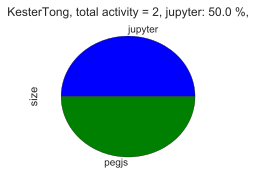

Activity grouped by repository (%):
source
jupyter    50
pegjs      50
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: MatthewTurk


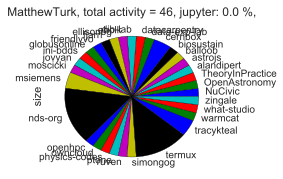

Activity grouped by repository (%):
source
NuCivic              2.17
OpenAstronomy        2.17
TheoryInPractice     2.17
alandipert           2.17
astrojs              2.17
balloob              2.17
biosustain           2.17
cernbox              4.35
data-exp-lab         2.17
datacarpentry        2.17
dib-lab              2.17
eholk                2.17
ellisonbg            2.17
fjarri               2.17
friendlyvo           2.17
globusonline         2.17
ini-bdds             2.17
jovyan               2.17
moscicki             2.17
msiemens             4.35
nds-org             15.22
openhpc              2.17
owncloud             2.17
physics-codes        2.17
ptone                2.17
ruven                2.17
simongog             2.17
termux              13.04
tracykteal           4.35
warmcat              2.17
what-studio          2.17
zingale              2.17
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for u

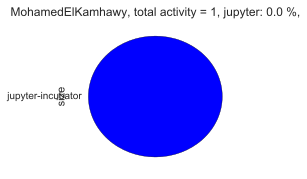

Activity grouped by repository (%):
source
jupyter-incubator    100
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: SylvainCorlay


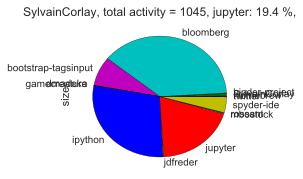

Activity grouped by repository (%):
source
Homebrew                0.19
SylvainCorlay           0.57
binder-project          0.19
bloomberg              38.28
bootstrap-tagsinput     7.75
dmadeka                 0.10
gamecreature            0.10
ipython                28.61
jdfreder                0.19
jupyter                19.43
mbostock                0.19
rossant                 0.10
spyder-ide              4.21
twitter                 0.10
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: aggFTW


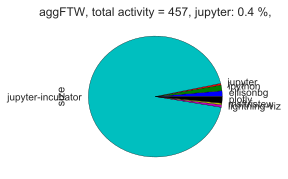

Activity grouped by repository (%):
source
ellisonbg             1.53
ipython               1.53
jupyter               0.44
jupyter-incubator    93.65
lightning-viz         0.66
msftristew            0.44
plotly                1.75
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: aisipos


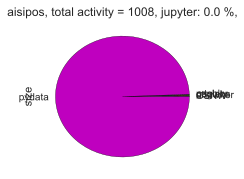

Activity grouped by repository (%):
source
CSNW        0.1
ahawker     0.3
cdglabs     0.1
pashky      0.1
pydata     99.4
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: alope107


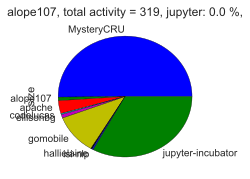

Activity grouped by repository (%):
source
MysteryCRU           50.16
alope107              0.94
apache                3.45
codelucas             0.31
ellisonbg             0.94
gomobile             10.66
hallielaine           0.31
isi-nlp               0.31
jupyter-incubator    32.92
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: ananelson
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: blink1073


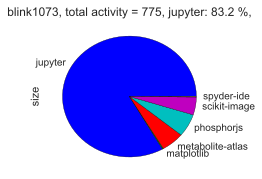

Activity grouped by repository (%):
source
jupyter             83.23
matplotlib           0.26
metabolite-atlas     5.55
phosphorjs           6.06
scikit-image         4.77
spyder-ide           0.13
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: bollwyvl


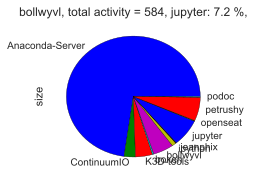

Activity grouped by repository (%):
source
Anaconda-Server    72.77
ContinuumIO         2.74
K3D-tools           4.11
bokeh               0.34
bollwyvl            4.97
ipython             1.03
jeanphix            0.17
jupyter             7.19
openseat            0.17
petrushy            6.34
podoc               0.17
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: cameronoelsen


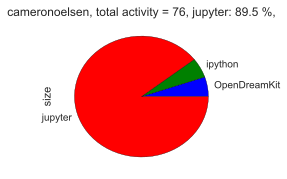

Activity grouped by repository (%):
source
OpenDreamKit     5.26
ipython          5.26
jupyter         89.47
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: captainsafia


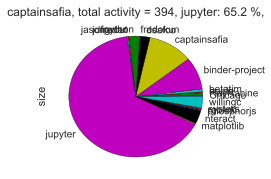

Activity grouped by repository (%):
source
Chicago            0.25
RayRacine          0.76
apple              0.25
betatim            0.76
binder-project     8.63
captainsafia      10.91
dsafco             2.28
fredokun           0.25
ipython            2.54
jasongrout         0.25
jdfreder           0.25
jupyter           65.23
matplotlib         0.25
nteract            3.55
phosphorjs         0.25
rgbkrk             0.25
systers            0.25
willingc           3.05
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: damianavila


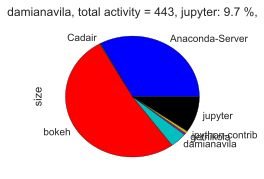

Activity grouped by repository (%):
source
Anaconda-Server    32.96
Cadair              0.23
bokeh              51.92
damianavila         4.06
getnikola           0.45
ipython-contrib     0.68
jupyter             9.71
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: dwillmer


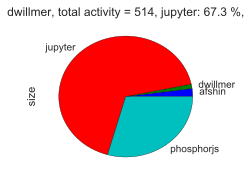

Activity grouped by repository (%):
source
afshin         2.14
dwillmer       1.17
jupyter       67.32
phosphorjs    29.38
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: ellachao


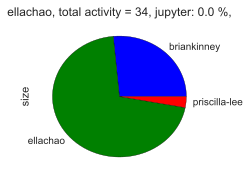

Activity grouped by repository (%):
source
briankinney      26.47
ellachao         70.59
priscilla-lee     2.94
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: ellisonbg


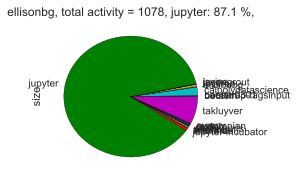

Activity grouped by repository (%):
source
betatim                 0.09
bootstrap-tagsinput     0.09
caesar0301              0.09
calpolydatascience      2.23
ellisonbg               0.19
ipython                 0.56
jasongrout              0.09
jsvine                  0.09
jupyter                87.11
jupyter-incubator       0.65
lmcinnes                0.09
martinal                0.09
minrk                   0.37
phosphorjs              0.19
plotly                  0.28
podoc                   0.28
quantopian              0.09
sympy                   0.09
takluyver               7.33
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: fhoffa


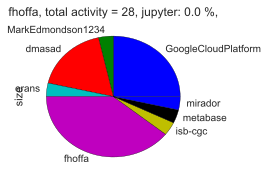

Activity grouped by repository (%):
source
GoogleCloudPlatform    25.00
MarkEdmondson1234       3.57
dmasad                 17.86
erans                   3.57
fhoffa                 39.29
isb-cgc                 3.57
metabase                3.57
mirador                 3.57
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: fperez


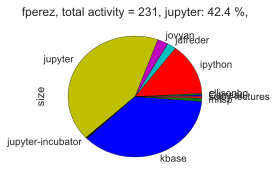

Activity grouped by repository (%):
source
Carreau               0.43
ellisonbg             0.43
ipython              13.85
jdfreder              2.16
jovyan                2.60
jupyter              42.42
jupyter-incubator     0.43
kbase                36.36
mltsp                 0.87
scipy-lectures        0.43
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: gnestor


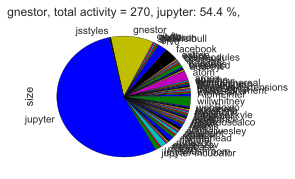

Activity grouped by repository (%):
source
AtomLinter              0.74
FaridSafi               0.37
JeanLebrument           0.37
MitocGroup              0.37
Reactive-Extensions     0.37
ReactiveX               0.37
Shuangzuan              0.37
Yomguithereal           0.37
aksonov                 0.37
apache                  0.37
arqex                   0.37
atom                    2.59
audreyt                 0.37
brianmcd                0.37
buggerjs                0.37
cdglabs                 1.11
codesuki                0.37
css-modules             0.37
eslint                  0.37
estree                  0.37
facebook                3.33
fv0                     2.22
gabrielbull             0.37
gaearon                 0.37
garth                   0.37
git-ftp                 0.37
gnestor                10.37
jsstyles                0.37
jupyter                54.44
jupyter-incubator       1.11
legomushroom            0.37
magus                   1.48
metabase                0.37


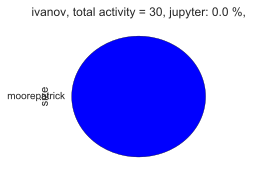

Activity grouped by repository (%):
source
moorepatrick    100
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: jasongrout


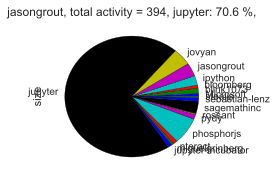

Activity grouped by repository (%):
source
Microsoft             0.76
blink1073             1.52
bloomberg             0.76
ipython               2.54
jasongrout            3.55
jovyan                4.57
jupyter              70.56
jupyter-incubator     1.02
miguelgrinberg        0.51
nteract               1.02
phosphorjs            7.11
pydy                  1.27
rossant               0.25
sagemathinc           3.30
sebastian-lenz        1.02
stealjs               0.25
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: jdfreder


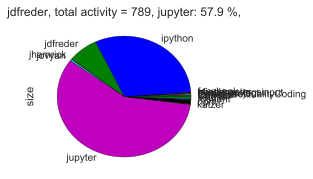

Activity grouped by repository (%):
source
Calysto                     0.13
Carreau                     0.25
EnterpriseQualityCoding     0.13
binder-project              0.25
bootstrap-tagsinput         0.13
cfjedimaster                0.13
facebook                    0.13
ipython                    30.93
jdfreder                    7.22
jhamrick                    0.13
jovyan                      0.51
jupyter                    57.92
katzer                      0.13
npm                         1.14
rossant                     0.25
vaultjs                     0.63
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: jeremiahbuddha
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: jhamrick


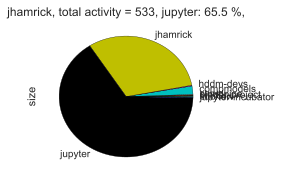

Activity grouped by repository (%):
source
HIPS                  0.19
binder-project        0.19
cloudpipe             0.19
compmodels            2.25
hddm-devs             0.19
jhamrick             31.14
jupyter              65.48
jupyter-incubator     0.19
suchow                0.19
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: jsnydes
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: jstenar


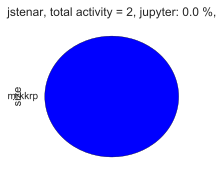

Activity grouped by repository (%):
source
mrkkrp    100
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: jtigani
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: jtyberg


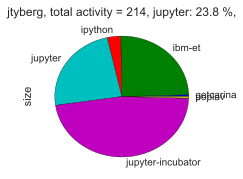

Activity grouped by repository (%):
source
getcarina             0.47
ibm-et               24.77
ipython               3.27
jupyter              23.83
jupyter-incubator    47.20
poplav                0.47
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: juliantaylor


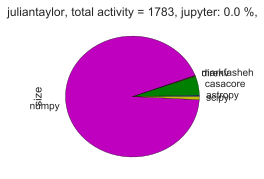

Activity grouped by repository (%):
source
astropy        0.34
casacore       5.16
direnv         0.17
markfasheh     0.06
numpy         93.44
scipy          0.84
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: kayur


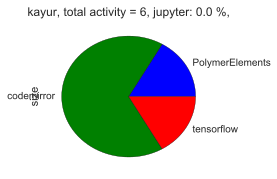

Activity grouped by repository (%):
source
PolymerElements    16.67
codemirror         66.67
tensorflow         16.67
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: lbustelo


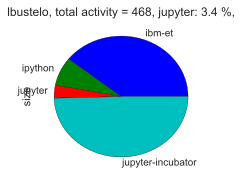

Activity grouped by repository (%):
source
ibm-et               39.32
ipython               7.69
jupyter               3.42
jupyter-incubator    49.57
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: lphk92


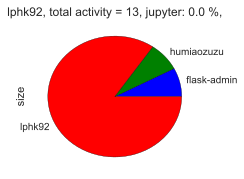

Activity grouped by repository (%):
source
flask-admin     7.69
humiaozuzu      7.69
lphk92         84.62
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: marksandler2
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: minrk


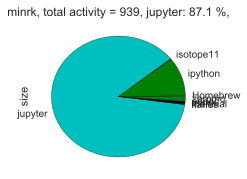

Activity grouped by repository (%):
source
Homebrew      0.21
ipython      10.44
isotope11     0.11
jupyter      87.11
karies        0.11
martinal      0.11
minrk         0.53
podoc         0.11
zeromq        1.28
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: msftristew


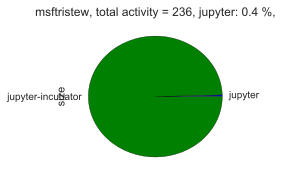

Activity grouped by repository (%):
source
jupyter               0.42
jupyter-incubator    99.58
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: ocefpaf


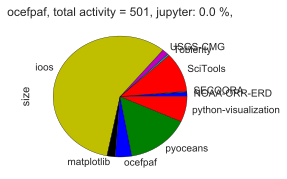

Activity grouped by repository (%):
source
NOAA-ORR-ERD             1.20
SECOORA                  0.20
SciTools                10.58
Toblerity                0.40
USGS-CMG                 1.60
ioos                    57.88
matplotlib               2.00
ocefpaf                  3.99
pyoceans                15.37
python-visualization     6.79
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: parente


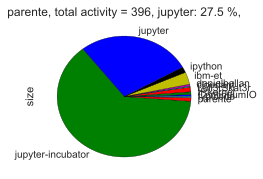

Activity grouped by repository (%):
source
ContinuumIO           0.51
IRkernel              0.76
Lull3rSkat3r          1.26
cloudant              0.25
danielballan          0.51
ibm-et                3.28
ipython               1.52
jupyter              27.53
jupyter-incubator    63.13
parente               1.01
typicode              0.25
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: priscilla-lee


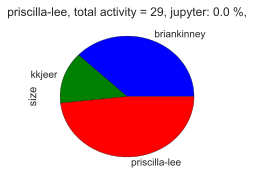

Activity grouped by repository (%):
source
briankinney      37.93
kkjeer           13.79
priscilla-lee    48.28
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: randallmunroe
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: rgbkrk


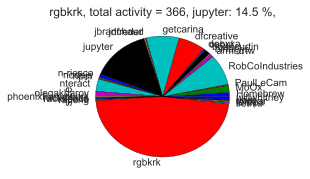

Activity grouped by repository (%):
source
Homebrew             1.09
MoOx                 1.91
PaulLeCam            0.27
RobCoIndustries      8.20
armstrtw             0.82
binaryjs             0.27
briancurtin          1.37
cabul                0.27
deoxxa               0.27
dfcreative           6.56
getcarina            7.92
jbranchaud           0.27
jdfreder             0.27
jupyter             14.48
n-riesco             0.82
nodejs               0.27
npm                  0.27
nteract              3.28
olegakbarov          1.37
phoenixframework     0.27
rackerlabs           0.27
rackspace            0.27
rauchg               0.27
rgbkrk              46.99
sethlu               0.27
teropa               0.27
tmpvar               0.27
uber                 0.27
willwhitney          0.82
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: richvn
*** This user had NO Github activity for this period ***
---------

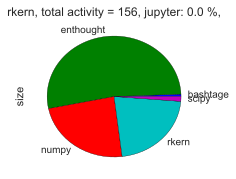

Activity grouped by repository (%):
source
bashtage      0.64
enthought    52.56
numpy        23.72
rkern        21.79
scipy         1.28
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: sangeethashekar
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: sccolbert


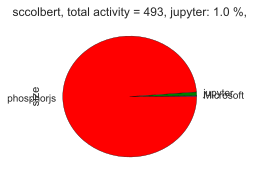

Activity grouped by repository (%):
source
Microsoft      0.20
jupyter        1.01
phosphorjs    98.78
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: slojo404
*** This user had NO Github activity for this period ***
-----------------------------------------------------------------
Summary of GitHub Activity for user: smashwilson


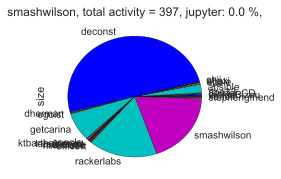

Activity grouped by repository (%):
source
IonicaBizau        0.50
Strider-CD         0.25
abe33              0.25
ansible            2.27
apple              0.25
atiaxi             0.25
chjj               0.25
deconst           50.13
dherman            0.25
egoist             0.25
getcarina          7.56
google             0.25
ktbartholomew      0.25
letsencrypt        0.25
mehcode            0.25
nixomose           0.25
officert           0.25
rackerlabs        16.62
smashwilson       19.14
stephengfriend     0.25
xenolf             0.25
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: ssanderson


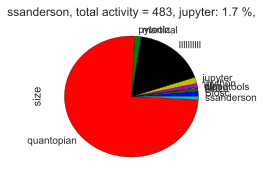

Activity grouped by repository (%):
source
Blosc          1.45
blaze          0.62
cloudtools     0.21
dfm            0.21
ipython        1.04
jupyter        1.66
llllllllll    17.39
martinal       0.21
pytoolz        1.45
quantopian    74.95
ssanderson     0.83
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: sumitsahrawat


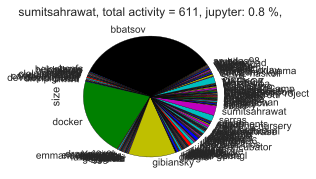

Activity grouped by repository (%):
source
222464               0.16
AndreaCrotti         0.16
Bromeon              0.16
Bumblebee-Project    0.16
CIFASIS              0.16
DaveDavenport        0.16
EpicGames            0.16
Erikhht              0.16
FranklinChen         0.33
FreeCodeCamp         0.16
Gabriel439           0.16
GaloisInc            0.49
KDE                  0.33
Malabarba            0.33
Microsoft            0.16
NARKOZ               0.16
OSGeo                0.16
SFML                 1.80
SFML-haskell         0.16
Sarcasm              0.49
ShingoFukuyama       0.16
SylvainCorlay        0.33
Thibaut              0.16
aanand               0.16
abingham             0.16
abo-abo              0.33
agarden              0.16
agentm               0.16
alexott              0.33
andrew               0.16
                     ... 
najela               0.16
nh2                  0.16
numerals             0.65
odewahn              0.16
ongaeshi             0.16
plotly               

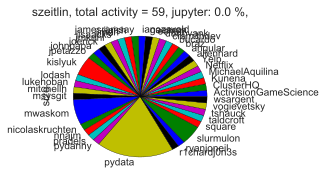

Activity grouped by repository (%):
source
ActivisionGameScience     1.69
ClusterHQ                 1.69
Kunena                    1.69
MichaelAquilina           1.69
Netflix                   1.69
Yelp                      1.69
alienhard                 1.69
angular                   1.69
braz                      1.69
bucardo                   1.69
crsmithdev                1.69
dunovank                  1.69
echen                     1.69
gaearon                   1.69
ianozsvald                1.69
jamesramsay               1.69
jigish                    1.69
jimeh                     1.69
jisaacks                  1.69
jmkoni                    1.69
joerick                   1.69
johnpapa                  1.69
jpetazzo                  1.69
kislyuk                   5.08
lodash                    1.69
lukehoban                 1.69
mitchellh                 1.69
msysgit                   1.69
mwaskom                   6.78
nicolaskruchten           1.69
nnajm                     1

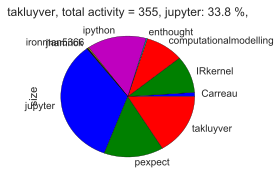

Activity grouped by repository (%):
source
Carreau                    1.13
IRkernel                   9.86
computationalmodelling     9.30
enthought                  0.28
ipython                   14.37
ironman5366                0.28
jhamrick                   0.28
jupyter                   33.80
pexpect                   14.37
takluyver                 16.34
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: vonmoltke


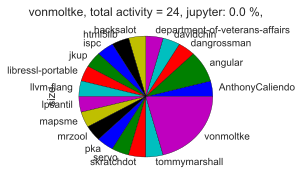

Activity grouped by repository (%):
source
AnthonyCaliendo                    4.17
angular                            8.33
dangrossman                        4.17
davidchin                          4.17
department-of-veterans-affairs     4.17
hacksalot                          4.17
html5lib                           4.17
ispc                               4.17
jkup                               4.17
libressl-portable                  4.17
llvm-flang                         4.17
lpsantil                           4.17
mapsme                             4.17
mrzool                             4.17
pka                                4.17
servo                              4.17
skratchdot                         4.17
tommymarshall                      4.17
vonmoltke                         20.83
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: williamstein


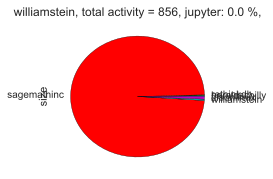

Activity grouped by repository (%):
source
haraldschilly     0.23
rethinkdb         0.23
sagemathinc      98.48
williamstein      0.35
zfsonlinux        0.70
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: willingc


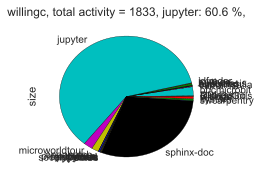

Activity grouped by repository (%):
source
DjangoGirls        0.05
RPi-Distro         0.11
audreyr            0.05
bbcmicrobit        2.40
captainsafia       0.16
ellisonbg          0.11
funkyHat           0.05
hypothesis         0.05
ipython            0.55
jdfreder           0.11
jupyter           60.56
microworldtour     2.18
openhatch          1.69
projectmesa        0.11
python             0.27
pythonsd           0.05
realpython         0.05
rossant            0.11
snide              0.05
socalpyladies      0.11
sphinx-doc        30.01
swcarpentry        0.05
systers            0.55
willingc           0.55
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: willnorris


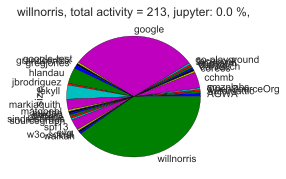

Activity grouped by repository (%):
source
AGWA              0.94
Automattic        0.47
OpenSourceOrg     0.47
amznlabs          0.47
cchmb             4.23
coreos            0.47
danleech          0.47
diafygi           0.47
encharm           0.47
facebook          0.47
go-playground     0.47
google           30.99
google-test       0.47
grandcentrix      0.47
gregjones         0.94
hlandau           4.23
jbrodriguez       0.47
jekyll            3.76
markjaquith       2.82
matgoebl          0.47
mvdan             0.47
oneuijs           0.47
pfefferle         0.47
sindresorhus      0.47
sourcegraph       0.47
spf13             2.82
svg               0.47
w3c-social        0.47
walkah            0.47
willnorris       39.44
Name: size, dtype: float64
-----------------------------------------------------------------
Summary of GitHub Activity for user: willwhitney


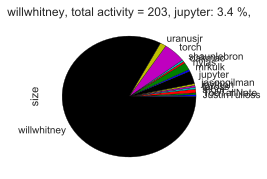

Activity grouped by repository (%):
source
JustinTulloss     0.49
TooTallNate       0.49
atom              0.99
feross            0.49
ipython           0.49
jasongilman       0.49
jupyter           3.45
mrkulk            0.49
nylas             1.97
oakmac            0.49
shaunlebron       0.49
torch             5.42
uranusjr          1.48
willwhitney      82.76
Name: size, dtype: float64
-----------------------------------------------------------------


In [83]:
for member in gh_summary:
    gh_activity(member)